In [261]:
# program for analyzing some of my facebook conversations
import numpy as np
import pandas as pd
import os
import json
import re
import glob
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

path = 'D:\\Python\\fb convo analysis'

In [262]:
# function that gets all json files from directory depending on the query
def get_message(query):
    message_list = []
    message_path = os.path.join(path, 'facebook-shawnliu90\messages\inbox')
    # searching through message_path for query
    message_folder = os.listdir(message_path)
    # combining message path with the file name to get that specific person's messages
    message_file = os.path.join(message_path, list(filter(lambda x: query in x, message_folder))[0])
    # changing file path to message_file and finding all json files containing messages
    os.chdir(message_file)
    read_files = glob.glob('*.json')
    # appends each json to a list of jsons
    for file in read_files:
        with open(file, "rb") as infile:
            message_list.append(json.load(infile))
    return message_list

In [263]:
# function that formats the message into one big string for word cloud
def format_message(text):
    message_string = ''
    for content in text['messages']:
        if 'content' in content.keys():
            # Appends all text into one big string
            message_string = message_string + ' ' + content['content']
    # Removing leading and trailing spaces
    message_string = message_string.rstrip().lstrip()
    return message_string

In [264]:
# removing junk words by adding to stopwords
junk_words = {'lol', 'yeah', 'okay', 'thank', 'thanks', 'you', 'man'
              'go', 'think', 'oh', 'ok','that', 'thats', 'yo', 'ya', 'bro', 'im', 'ye'}

for word in junk_words:
    STOPWORDS.add(word)

# wordcloud function
def create_wordcloud(text):
    # mask image for the shape of the cloud
    mask = np.array(Image.open(os.path.join(path, 'mask.png')))
    # filtering out stopwords like the, and, is, etc.
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white', mask=mask, max_words=200, stopwords=stopwords)
    # generating the wordcloud
    wc.generate(text)
    return wc

In [265]:
# function that converts the date in text for purposes of plotting 
def date_conversion(text):
    # converting timestamps into dates, first by dividing out the milliseconds in the timestamps
    text['timestamp_ms'] = text['timestamp_ms']//1000
    # iterating and appending onto a list, then replacing the timestamp column with the date list
    date_list = []
    for timestamp in text['timestamp_ms']:
        timestamp = datetime.fromtimestamp(timestamp)
        date_list.append(timestamp)
    text['timestamp_ms'] = date_list
    return text

In [266]:
# TBD more complicated stuff
def context_analysis(text):
    ''' 
    using spacy and other nlp libraries to do some more advanced analysis 
    - context
    - named entities
    - similar conversations between different people
    '''

In [267]:
# executing function that gets the list of message files 
main_text = get_message('AlysaaCoco')

In [268]:
# formatting and creating wordcloud
main_text_wordcloud = ""

# iterate over each json and extraxt all content into one string
for text in main_text:
    main_text_wordcloud = main_text_wordcloud + format_message(text).lower()
cloud = create_wordcloud(main_text_wordcloud)

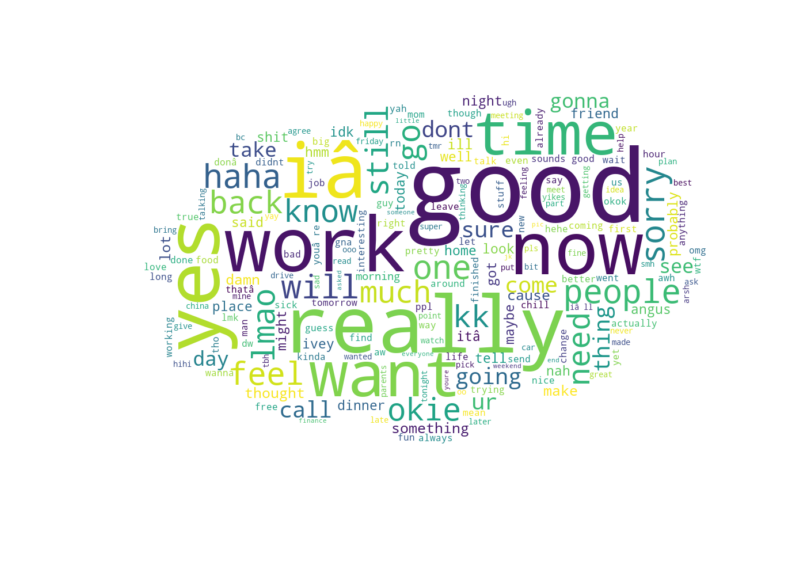

In [269]:
# showing the wordcloud in a plot
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

In [270]:
# iterate over each json, converting it to a dataframe
main_text_list = []
for text in main_text:
    text = pd.DataFrame.from_dict(text['messages'])
    main_text_list.append(text)

In [271]:
# merge into on dataframe
main_text_df = pd.concat(main_text_list, sort = False)

# grabbing the timestamp, sender, content, and type
main_text_df = main_text_df[['sender_name', 'timestamp_ms', 'content', 'type']]

# converting timestamp to datetime
main_text_df_ts = date_conversion(main_text_df)
main_text_df_ts.head()

,sender_name,timestamp_ms,content,type
0,Alysaa Coco,2019-12-19 18:41:55,Sorry that was long,Generic
1,Alysaa Coco,2019-12-19 18:41:52,But I could easily cut Vietnam if need be,Generic
2,Alysaa Coco,2019-12-19 18:41:41,Cause i havenât been to those,Generic
3,Alysaa Coco,2019-12-19 18:41:33,"I think my top places are Bali, parts of Thail...",Generic
4,Alysaa Coco,2019-12-19 18:41:19,And I go back to HK so often that Iâll alway...,Generic


In [272]:
# how many total messages did we send to each other?
total_msgs = len(main_text_df_ts)
print(total_msgs)

20997


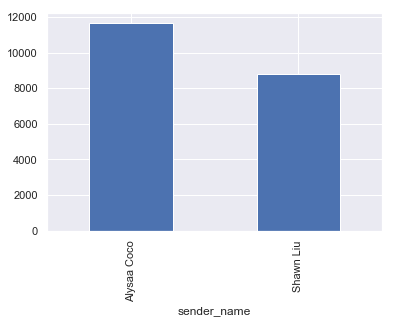

In [273]:
# who sent more messages?
main_text_df_ts.groupby('sender_name')['content'].count().plot(kind = 'bar')

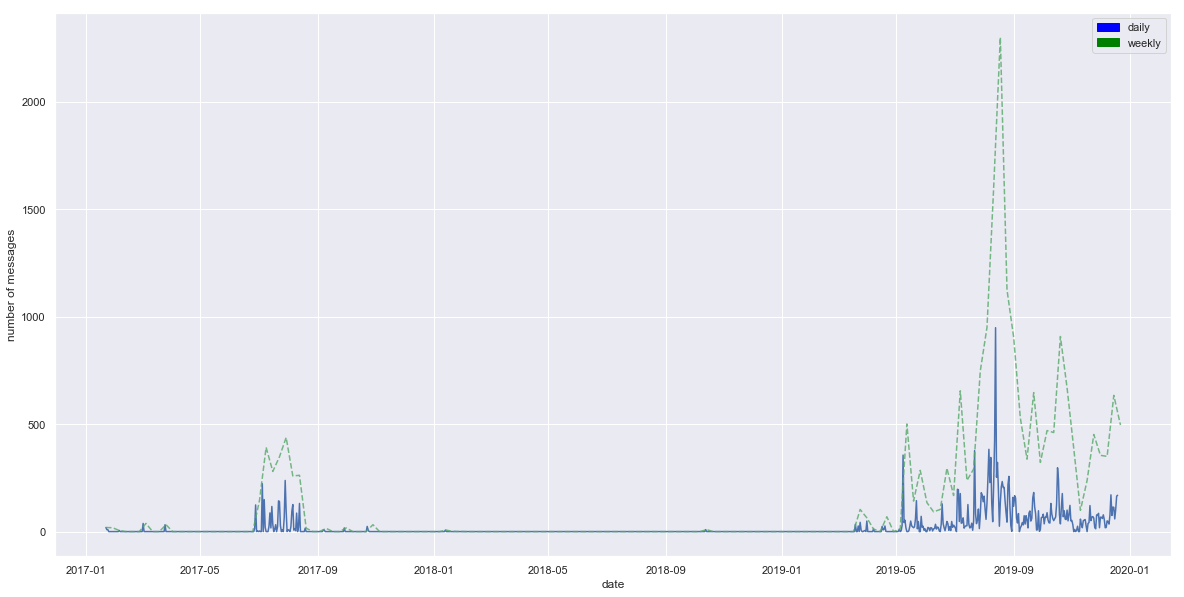

In [274]:
# grouping by day and week
messages_day = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'D')).count()
messages_week = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()

# plotting daily messages
sns.set()
plt.figure(figsize=(20,10))
plt.plot(messages_day['content'], color = 'b', alpha = 1)
plt.plot(messages_week['content'], color = 'g', alpha = 0.8, linestyle = '--')
plt.xlabel('date')
plt.ylabel('number of messages')
legend_daily = mpatches.Patch(color = 'blue', label = 'daily')
legend_weekly = mpatches.Patch(color = 'green', label = 'weekly')
plt.legend(handles=[legend_daily, legend_weekly])

plt.show()

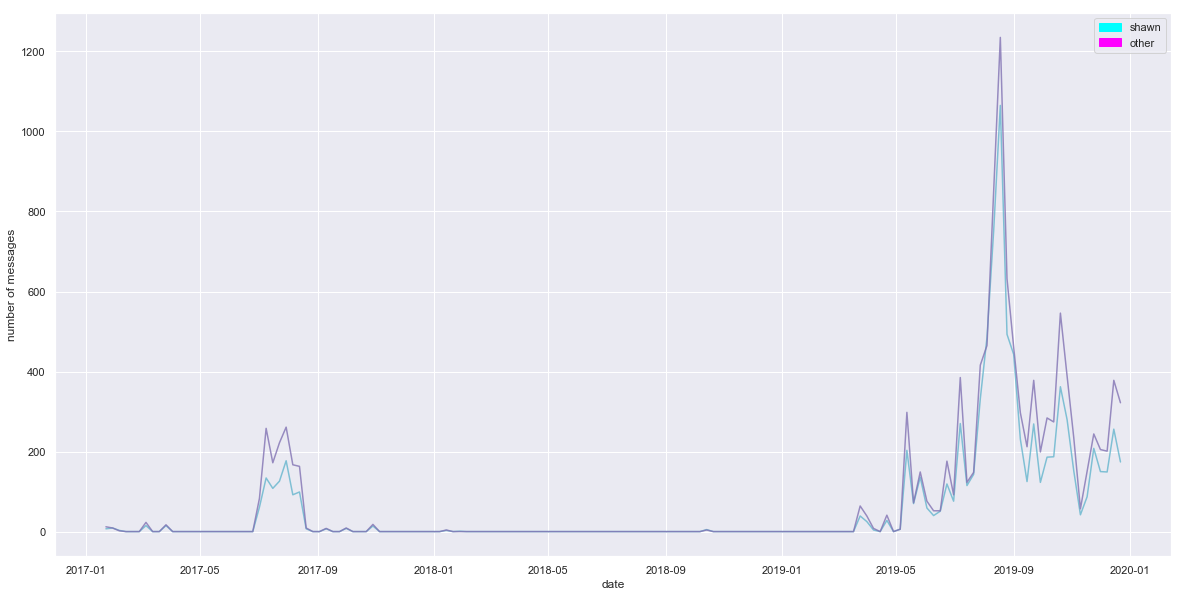

In [275]:
# splitting up weekly messages by sender name
messages_day_shawn = main_text_df_ts[main_text_df_ts['sender_name'] == 'Shawn Liu']\
.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()
messages_day_other = main_text_df_ts[main_text_df_ts['sender_name'] != 'Shawn Liu']\
.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()

# plotting weekly messages by sender
plt.figure(figsize=(20,10))
plt.plot(messages_day_shawn['content'], color = 'c', alpha = 0.8)
plt.plot(messages_day_other['content'], color = 'm', alpha = 0.8)
plt.xlabel('date')
plt.ylabel('number of messages')
legend_shawn = mpatches.Patch(color = 'cyan', label = 'shawn')
legend_other = mpatches.Patch(color = 'magenta', label = 'other')
plt.legend(handles=[legend_shawn, legend_other])

plt.show()

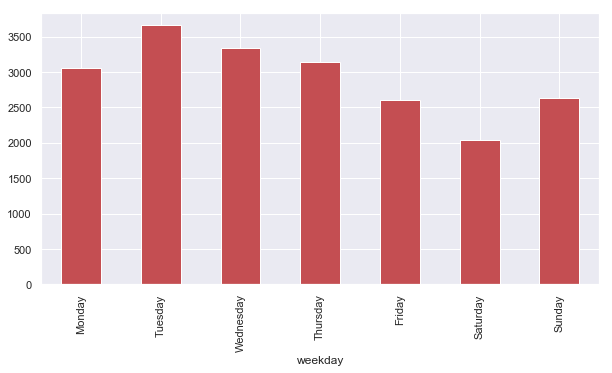

In [276]:
# dictionary and list of weekdays to map onto df and sort
weekdays_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekdays_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# creating a weekday column with dt.dayoftheweek, then mapping to names of weekdays for clarity
main_text_df_ts['weekday'] = main_text_df_ts['timestamp_ms'].dt.dayofweek
main_text_df_ts['weekday'] = main_text_df_ts['weekday'].map(weekdays_dict)

# sorting by weekdays to maintain the order to days in the plot
main_text_df_ts['weekday'] = pd.Categorical(main_text_df_ts['weekday'], categories = weekdays_list, ordered = True)
main_text_df_ts = main_text_df_ts.sort_values('weekday')

# weekday plots
main_text_df_ts.groupby('weekday')['content'].count().plot(kind = 'bar',figsize = (10,5), color = 'r')

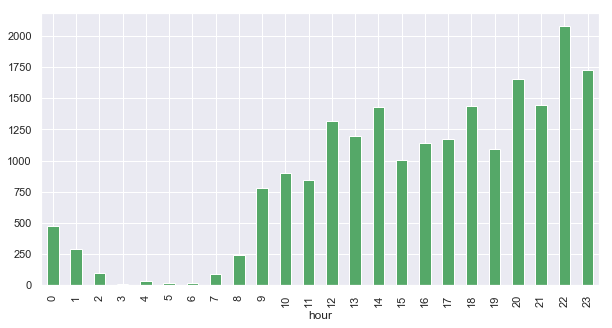

In [277]:
# creating a hour column with dt.hour, then sorting
main_text_df_ts['hour'] = main_text_df_ts['timestamp_ms'].dt.hour
main_text_df_ts = main_text_df_ts.sort_values('hour')

# hourly plot
main_text_df_ts.groupby('hour')['content'].count().plot(kind = 'bar', figsize = (10,5), color = 'g')

In [ ]:
# sentiment analysis